In [1286]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import isnan

In [1287]:
conn = sqlite3.connect('data/attrition.db')
df = pd.read_sql_query('SELECT * FROM attrition', conn)
df

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time
0,1d172e75-2c13-4b73-a1da-18d442a10bf7,1,41,Female,5993,0.2 hours,Diploma,Engineering,2,Changi,Gold,7,1981,7
1,6dee0995-9ff1-44a6-b3f1-fc5f7270c8ab,0,49,Male,5130,0.7 hours,Diploma,Engineering,3,Thomson,Normal,11,1973,2
2,c9fff882-42e7-4e12-88ab-74aba95113dc,1,37,Male,2090,20.0 mins,Diploma,Medical,4,Thomson,Normal,1,1985,2
3,1521db93-82d8-46a8-9718-6acde2a7c001,0,33,Female,2909,20.0 mins,Master,Engineering,4,Thomson,Normal,9,1989,0
4,e8a69be8-c96a-4f37-b14c-b3c75aa32db3,0,27,Male,3468,0.3 hours,Diploma,Information Technology,1,Thomson,Normal,3,1995,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,853c0e3d-102d-4f0a-8eaf-77ab3ee6eb9e,0,55,Male,7168,0.4 hours,Master,Medical,3,Changi,Bronze,10,-1,5
2466,ffaa8f3e-845c-4609-86ba-c64162fd08be,1,28,Male,9138,53.61316468923773 mins,Diploma,Engineering,3,Changi,Normal,11,1994,3
2467,df9097af-60f5-4654-b479-75ce35ef2c9b,0,55,Male,11845,0.5 hours,Master,Engineering,3,Thomson,Normal,4,1967,5
2468,5675bfe3-c90a-47bb-b6c2-5d6e2005ef54,0,42,Female,12579,31.884495613579915 mins,Bachelor,Business,1,Changi,Silver,5,1980,2


Lets start by getting the shape of our dataset so we know what we are working with. 

In [1288]:
df.shape

(2470, 14)

We have 2470 datapoints and 14 columns. But one of the columns is what are are trying to predict (Attrition) so we have 13 features to analyse. Lets start by checking if there are any null values. 

In [1289]:
df.isna().sum()

Member Unique ID    0
Attrition           0
Age                 0
Gender              0
Monthly Income      0
Travel Time         0
Qualification       0
Work Domain         0
Usage Rate          0
Branch              0
Membership          0
Months              0
Birth Year          0
Usage Time          0
dtype: int64

There seems to be no missing datapoints which is great! Now lets take a look at each individual column and check that there are no incorrect entries or values that do not make sense. We will start by just getting a quick overview of the numerical data

In [1290]:
df.describe()

,Attrition,Age,Monthly Income,Usage Rate,Months,Birth Year,Usage Time
count,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000
mean,0.169636,35.970850,5143.199595,2.780972,10.634413,1734.040486,4.846964
std,0.375388,16.757217,6542.273046,1.033757,9.225734,655.077597,3.925911
min,0.000000,-1.000000,-24620.000000,1.000000,0.000000,-1.000000,0.000000
25%,0.000000,29.000000,2610.000000,2.000000,5.000000,1969.000000,2.000000
50%,0.000000,38.000000,4785.000000,3.000000,8.000000,1980.000000,4.000000
75%,0.000000,48.000000,7981.750000,4.000000,13.000000,1988.000000,6.000000
max,1.000000,69.000000,25326.000000,4.000000,57.000000,2004.000000,20.000000


There do seem to be a few issues that I can see just from this table. 
    1. There is a negative age. 
    2. There is a negative monthly income
    3. There is a negative birth year
Now lets take a look at each column individually

## Data Cleaning

We will ignore Member Unique ID as I do not think that a unique ID would in any way be useful to helping to predict attrition. 

#### Attrition

In [1291]:
df['Attrition'].unique()

array([1, 0])

Thankfully there are no issues with Attrition. If there were, that would be a major issue as this is the value we are predicting. 

#### Age

We know from earlier, that there are some negative values within this column. Lets take a closer look

In [1292]:
df['Age'][df['Age']<=0].count()

291

This seems to be a big issue. There are 291 data points with negative ages. This is more than 10% of our dataset. We cannot just delete 10% of our dataset. So we will have to consider either fixing these incorrect points or deleting the column all together. Lets take a closer look at what negative values there are for age. 

In [1293]:
df['Age'].loc[df['Age'] <= 0].unique()

array([-1])

So all the negative values are -1. We have incorrectly labelled datapoints. Lets take a look at the spread of the rest of the datapoints. We will take a look at a boxplot and a distribution plot.

<AxesSubplot: >

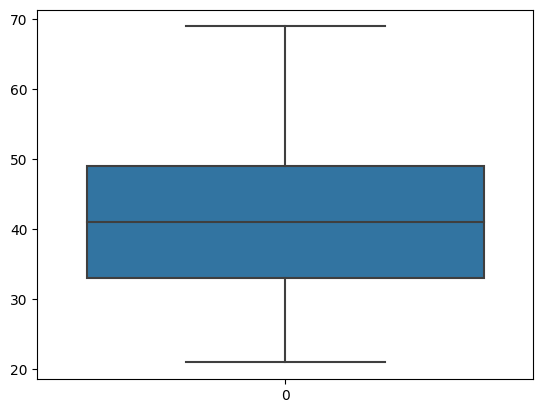

In [1294]:
sns.boxplot(df['Age'][df['Age']>=21])

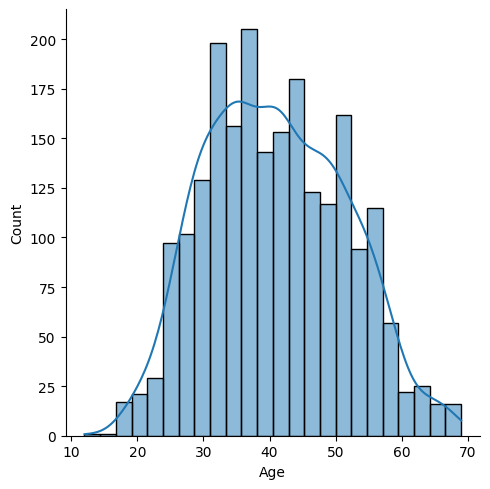

In [1295]:
sns.displot(df['Age'][df['Age']>0], kde = True)

The rest of the data (Age >=21) seems to be relatively non-skewed. Almost looks normally distributed. I think based on these plots, using the mean of the non-negative datapoints (rounded to the nearest whole number) would be an appropriate way to fill in the negative values. However, I have decided to go a different route which will be explained at a later section. 

#### Gender

Lets start by taking a look at the unique values within this feature

In [1296]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

We note that before we run any models using this feature, we will need to convert it. However, for the purposes of this eda, we will leave it as male/female. If we choose to use this feature, we will convert it using one-hot encoding. 

#### Monthly Income

Lets take a look at the monthly income feature. We know from above that there is at least one negative value within the feauture. 

In [1297]:
df['Monthly Income'][df['Monthly Income']< 0].count()

299

There are 299 negative values within this feature. Lets take a closer look at them. 

In [1298]:
np.sort(df['Monthly Income'][df['Monthly Income']< 0].unique())

array([-24620, -20704, -20703, -20218, -20115, -20114, -20054, -19999,
       -19926, -19818, -19665, -19658, -19537, -19094, -19049, -18990,
       -18947, -18722, -18606, -17266, -17261, -16892, -16823, -16659,
       -16559, -16328, -16200, -16109, -16064, -16034, -15992, -15306,
       -15168, -14484, -13940, -13826, -13402, -13320, -13120, -12936,
       -12896, -12735, -12328, -12323, -12276, -12207, -12161, -12111,
       -11890, -11713, -10880, -10851, -10820, -10800, -10725, -10673,
       -10609, -10496, -10467, -10453, -10377, -10333, -10231, -10159,
        -9991,  -9888,  -9852,  -9824,  -9724,  -9714,  -9439,  -9414,
        -9274,  -9256,  -8817,  -8755,  -8644,  -8607,  -8606,  -8599,
        -8542,  -8450,  -8398,  -8380,  -8350,  -8181,  -8146,  -8048,
        -8008,  -7980,  -7882,  -7779,  -7674,  -7654,  -7642,  -7560,
        -7553,  -7512,  -7327,  -7171,  -7005,  -6940,  -6885,  -6849,
        -6833,  -6815,  -6755,  -6737,  -6725,  -6635,  -6557,  -6496,
      

There are many different negative values. Lets take a look at the distribution of them. 

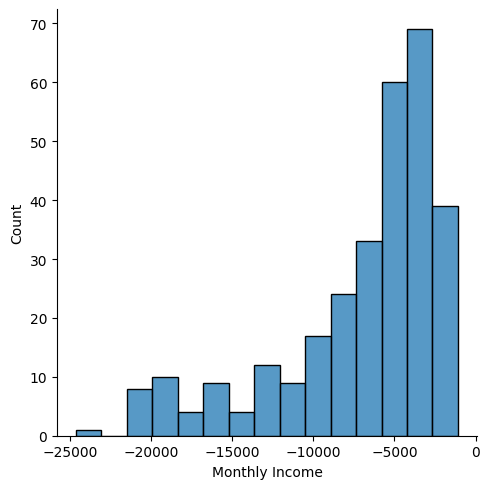

In [1299]:
sns.displot(df['Monthly Income'][df['Monthly Income']< 0])

So so the fact that its weighted towards the lower incomes as well as the fact that there are so many different unique negative values, is leading me to believe that a negative sign (-) was incorrectly added to these datapoints. I suspect that the distribution plot of the positive incomes will look like a reflection on the y axis of this histogram.  

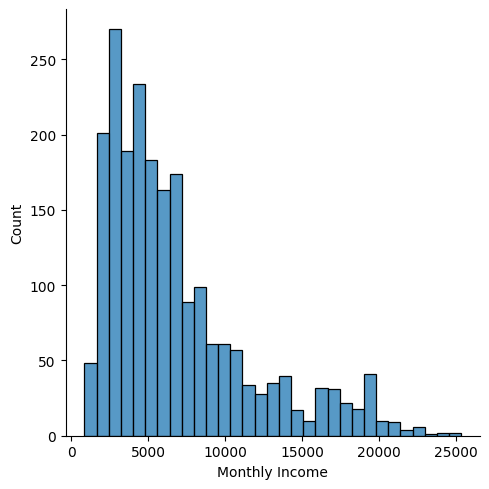

In [1300]:
sns.displot(df['Monthly Income'][df['Monthly Income']>0])

As suspected, it does. Therefore, I believe that the negative sign was added incorrectly. Will fix it by simply getting rid of the negative sign. 

In [1301]:
df['Monthly Income'] = df['Monthly Income'].abs()

#### Travel Time

Lets take a look at the travel time feature

In [1302]:
df['Travel Time'].unique()

array(['0.2 hours', '0.7 hours', '20.0 mins', '0.3 hours', '50.0 mins',
       '0.8 hours', '40.0 mins', '30.0 mins', '0.5 hours', '10.0 mins',
       '22.152170491849265 mins', '0.9 hours', '42.27732027062228 mins',
       '0.1 hours', '0.4 hours', '32.56739255726553 mins',
       '53.0473542956937 mins', '19.815236022824735 mins',
       '52.205729235648725 mins', '22.49412777253371 mins',
       '41.12707947908584 mins', '31.401497196062657 mins',
       '53.37674112017733 mins', '50.60372068235221 mins',
       '11.56004318189624 mins', '15.116187429153692 mins',
       '49.445802785304686 mins', '31.72861394229167 mins',
       '22.31098873338772 mins', '53.18722436287888 mins',
       '19.102285459123923 mins', '23.03104712045909 mins',
       '23.892979061709347 mins', '51.64755091792997 mins',
       '53.303308014961566 mins', '41.86978196397573 mins',
       '22.04441072020257 mins', '21.07218069435354 mins',
       '50.80163006842338 mins', '20.599094553649145 mins',
       '

So we see 2 things we need to think about here. Firstly, the data is recorded with 2 types. 
    1. mins
    2. hours
Secondly, the data is all recorded as strings. Lets deal with these issues. 

First lets check that hours and mins are the only 2 time measurements used.

In [1303]:
def checkTimeMeasurement(travelTime : str):
    return travelTime[-5:]
df.apply(lambda x: checkTimeMeasurement(x['Travel Time']), axis = 1).unique()

array(['hours', ' mins'], dtype=object)

So we now know, that there are only 2 ways that the time taken to arrive at the country club is recorded. Lets now convert everything to minutes so that its consistent across datapoints. The reason why minutes is chosen here, is just cause i prefer it. Additionally, I do not think that the decimal places are necessary for this column as when we have decimal points with minutes, it just means seconds. I do not think that the number of seconds more than a particular minute it takes to reach the country club would be relevant. 

In [1304]:
def convertTravelTimeToMinutes(travelTime : str):
    if travelTime[-5:] == 'hours':
        return int(np.round(float(travelTime[:-6])*60))
    else:
        return int(np.round(float(travelTime[:-6])))
df['Travel Time'] = df['Travel Time'].apply(convertTravelTimeToMinutes)

In [1305]:
df['Travel Time']

0       12
1       42
2       20
3       20
4       18
        ..
2465    24
2466    54
2467    30
2468    32
2469    22
Name: Travel Time, Length: 2470, dtype: int64

#### Qualification

In [1306]:
df['Qualification'].unique()

array(['Diploma', 'Master', 'Bachelor', 'Ph.D', "Bachelor's", "Master's",
       'Doctor of Philosophy'], dtype=object)

So we have several repeats of the same info but spelt slightly differently (some with apostrophe's, some without and different words to represent PhD). So lets fix that so that its all uniform. 

In [1307]:
def fixQualifications(qualifications: str):
    if qualifications == "Bachelor's":
        return 'Bachelor'
    if qualifications == "Master's":
        return 'Master'
    if qualifications == 'Doctor of Philosophy':
        return 'Ph.D'
    else: 
        return qualifications
df['Qualification'] = df['Qualification'].apply(fixQualifications)
df['Qualification'].unique()

array(['Diploma', 'Master', 'Bachelor', 'Ph.D'], dtype=object)

#### Work Domain

In [1308]:
df['Work Domain'].unique()

array(['Engineering', 'Medical', 'Information Technology', 'Business',
       'Science', 'Unemployed'], dtype=object)

There seem to be no issues with the Work Domain feature. 

#### Usage Rate

In [1309]:
df['Usage Rate'].unique()

array([2, 3, 4, 1])

No issues found with Usage Rate feature. 

#### Branch

In [1310]:
df['Branch'].unique()

array(['Changi', 'Thomson', 'Kranji'], dtype=object)

No issues found with Branch feature

#### Membership

In [1311]:
df['Membership'].unique()

array(['Gold', 'Normal', 'Bronze', 'Silver'], dtype=object)

No issues found. Although I am going to assume that the membership tiers go: Normal < Bronze < Silver < Gold. 

#### Months

In [1312]:
np.sort(df['Months'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 57])

No issues found with Months feature. 

#### Birth Year

In [1313]:
np.sort(df['Birth Year'].unique())

array([  -1, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004])

There is a negative value (-1) within the birth year feature. Lets take a closer look. 

In [1314]:
df['Birth Year'][df['Birth Year'] == -1].count()

308

There are 308 datapoints with negative values. We will deal with this in a later section together with the negative values of the Age feature. 

#### Usage Time

In [1315]:
np.sort(df['Usage Time'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

We note here that a usage time of 20 hours seems unrealistic as after a quick google, the country clubs in Singapore are open for at most 18 hours per day. We will assume that any datapoints with a usage time greater than that was a mistype and will just set any number greater than 18 to 18. 

In [1316]:
def changeUsageTime(usageTime: int):
    if usageTime > 18:
        return 18
    else:
        return usageTime
df['Usage Time'] = df['Usage Time'].apply(changeUsageTime)

In [1317]:
np.sort(df['Usage Time'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

#### Dealing with the negative values in Age and Birth Year feature

In this section, we will deal with the negative values found in the Age and Birth Year feature. This is because, theoretically, Age + Months = Actual Age of Client, where actual age of Client is calculated by taking the difference between Birth Year and 2022. Lets first consider whether its possible to fill all negative values using this method by first checking if there are any negative values in the same row for both features. 

For simplicity, we will change all negative values to NaaN as they are essentially the same thing i.e negative = missing

In [1318]:
df['Age'] = df['Age'].mask(df['Age']<0)
df['Birth Year'] = df['Birth Year'].mask(df['Birth Year']<0)
df[(df['Age'].isna())&(df['Birth Year'].isna())]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time


There are no datapoints where both Birth Year and Age are missing. We do not need to check the Months feature as we know from above, that no datapoints are missing. 

Lets now check and see if our idea abot Age + Months = Actual Age of the Member is a good way to fill in the missing values. We will first create a new column called 'Client Age' to get the actual age of the member calculated from their birth year. We will then check the difference between Age + Months and the Actual Age of the member.  

In [1319]:
df['Birth Year'] = df['Birth Year'].mask(df['Birth Year'] < 0)
df['Age'] = df['Age'].mask(df['Age'] < 0)
def convertYearToAge(birth_year :int):
    return 2022 - birth_year
df['Client Age'] = df['Birth Year'].apply(convertYearToAge)

In [1320]:
def checkAssumption(age_joining :float, age_current: float, num_months: float):
    return (age_joining + (num_months)/12) - age_current
df['Check Assumption'] = df.apply(lambda x: checkAssumption(x['Age'], x['Client Age'], x['Months']), axis = 1)
df['Check Assumption'].describe()

count    1871.000000
mean        0.881881
std         0.764586
min         0.000000
25%         0.416667
50%         0.666667
75%         1.000000
max         4.416667
Name: Check Assumption, dtype: float64

That is interesting. So there are situations where our theory is off by more than 4 years. Lets take a look at some of these datapoints. 

In [1321]:
df[df['Check Assumption'] > 2]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time,Client Age,Check Assumption
18,7dc2b0af-0f59-47b8-990f-2f19b6c13db6,0,53.0,Female,15427,20,Master,Engineering,1,Changi,Normal,26,1969.0,6,53.0,2.166667
98,b76eb2fc-710c-425f-9960-116d86db0b96,0,58.0,Male,13872,42,Master,Information Technology,4,Changi,Bronze,38,1964.0,1,58.0,3.166667
119,bca4f43a-80ec-4092-b2ac-b69da2a4477f,0,43.0,Male,16959,48,Diploma,Engineering,3,Changi,Silver,26,1979.0,7,43.0,2.166667
126,22eca069-e2ac-46ab-9c0c-11fd33bfb919,1,58.0,Female,10312,50,Master,Information Technology,4,Thomson,Bronze,41,1964.0,4,58.0,3.416667
178,b2618709-894f-49a1-a7f6-f2c74269147d,0,46.0,Female,10453,12,Diploma,Business,2,Changi,Normal,25,1976.0,4,46.0,2.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,3015e480-9d4f-4d7e-967a-f67306ae01d0,0,44.0,Male,14942,53,Bachelor,Engineering,3,Thomson,Normal,44,1978.0,5,44.0,3.666667
2405,bee68458-2c14-4a1d-b4e9-b39f077ea60c,0,43.0,Female,7242,24,Diploma,Information Technology,4,Thomson,Gold,27,1979.0,3,43.0,2.250000
2419,a8a786bc-ee9b-4bc8-b3f8-c1e2daf3b61a,0,47.0,Male,6505,23,Ph.D,Information Technology,2,Changi,Normal,50,1975.0,6,47.0,4.166667
2428,fcd95a4c-1a75-4488-8d75-69c264345230,0,44.0,Female,1133,31,Ph.D,Information Technology,3,Thomson,Normal,43,1978.0,3,44.0,3.583333


This is interesting. So it seems that there might be some mistakes made in the datapoints for either Age, Months and/or Birth Year. We will have to investigate this in the next section. However, first we will deal with the missing values for the Age and Birth Year features. 

We note that when using the equation above (Age + Months = Client Age), we were at most off by 4.4167 years with the mean being 0.88. Based on this, I conclude that using this method to fill in the missing values is likely to result in a Age and Birth Year closer to the true value than using a central tendancy method such as just filling missing values using mean/median. Therefore, we will fill in missing values using the equation above. 

In [1322]:
def fillInMissingAgeValues(join_age: float, current_age:float, months_member: int):
    if isnan(join_age):
        return np.round(current_age - (months_member/12))
    else:
        return join_age
df['Age'] = df.apply(lambda x: fillInMissingAgeValues(x['Age'], x['Client Age'], x['Months']), axis = 1)
df['Age'].isna().value_counts()

False    2470
Name: Age, dtype: int64

In [1323]:
def fillInMissingBirthYearValues(join_age:float, birth_year: int, months_member:int):
    if isnan(birth_year):
        return 2022 - np.round(join_age + (months_member/12))
    else:
        return birth_year
df['Birth Year'] = df.apply(lambda x: fillInMissingBirthYearValues(x['Age'], x['Birth Year'], x['Months']), axis = 1)
df['Client Age'] = df['Birth Year'].apply(convertYearToAge) #to fill in all the previously NaN values in Client Age
print(df['Client Age'].isna().value_counts())
df['Birth Year'].isna().value_counts()

False    2470
Name: Client Age, dtype: int64


False    2470
Name: Birth Year, dtype: int64

#### Possible mistakes made with Age, Months or Birth Year features

After examining some rows, I have realised that there is likely to be some errors in the recording of the Age/Months/Birth Year features based on my understanding of them. Lets take a look at some examples:

In [1324]:
df[['Age', 'Months', 'Birth Year', 'Client Age']][df['Check Assumption'] > 2]

,Age,Months,Birth Year,Client Age
18,53.0,26,1969.0,53.0
98,58.0,38,1964.0,58.0
119,43.0,26,1979.0,43.0
126,58.0,41,1964.0,58.0
178,46.0,25,1976.0,46.0
...,...,...,...,...
2391,44.0,44,1978.0,44.0
2405,43.0,27,1979.0,43.0
2419,47.0,50,1975.0,47.0
2428,44.0,43,1978.0,44.0


If we take a look at the first row (index 18), here we have a member that signed up as a member at age 53, has already been a member for 26 months (2 years and 2 months) and has a birth year of 1969 which implies the client is 53 years old this year(2022). All 3 features in this row cannot be true at the same time. Therefore, an incorrect entry was made in at least one of these feature entries. 

In my opinion, the most likely feature to be incorrect is Age as Birth Year would have been taken from the Member's identification provided when signing up for membership and Months would have just been gotten directly from the Country Club's system. Therefore, I will assume that in cases such as above, the features Birth Year and Months are correct and adjust the Age feature accordingly so all the numbers tally. 

To simplify the process, I am going to assume that all member's birthdays have already passed so when we do calculated their current age (Client Age feature) it is accurate. I am going to change adjust the Ages feature where the Check Assumption feature created which calculates the difference between (Age + Months) and Client Age is greater than or equal to 1. This is because, in those situations we can be 100% sure that there is an error as the numbers do not add up. 

In [1325]:
def correctAges(check_assumption : float, current_age: float, member_months: int, join_age: float):
    if check_assumption >= 1:
        return np.round(current_age - (member_months/12))
    else:
        return join_age

In [1326]:
df['Age'] = df.apply(lambda x: correctAges(x['Check Assumption'], x['Client Age'], x['Months'], x['Age']), axis = 1)
df['Check Assumption'] = df.apply(lambda x: checkAssumption(x['Age'], x['Client Age'], x['Months']), axis = 1)
df['Check Assumption'][(df['Check Assumption'] >=1) | (df['Check Assumption'] <=-1)].count() 

0

Lets now take a look at the distribution of Age after our changes and make sure there are no issues. 

In [1327]:
df['Age'].describe()

count    2470.000000
mean       40.331984
std        10.360449
min        12.000000
25%        32.000000
50%        40.000000
75%        48.000000
max        69.000000
Name: Age, dtype: float64

This is interesting. The youngest member joined at the age of 12. This seems a bit young to be a member of a country club. 

After a quick google, the youngest age that a person could be a member of a country club is 18 years old. Lets take a look at all the members who joined at under the age of 18.

In [1328]:
df[df['Age'] < 18]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time,Client Age,Check Assumption
1833,978342bd-10ce-4c9a-b243-dd23701b5a20,0,12.0,Female,10058,12,Master,Engineering,2,Thomson,Normal,14,2009.0,5,13.0,0.166667
1992,21a01ceb-82e4-46ae-b4cd-942ea393c456,0,17.0,Male,4012,13,Diploma,Business,1,Thomson,Normal,10,2004.0,14,18.0,-0.166667
2215,d47a3d50-ca65-4765-9508-3352a7b437c4,0,15.0,Female,3920,42,Master,Business,2,Thomson,Normal,7,2006.0,2,16.0,-0.416667


So it seems that this country club has a lot of extremely smart youngsters. With them having a 12 year old female with a Masters degree and earning $10000 per month, a 15 year old female with a Master's degree. I am going to treat the 2 female members as corurpt data and just delete them. This is because, the age, income and qualification do not sense. 

As for the 17 year old male member, I think considering the Birth Year is 2004, and the Months is only 10, I will just assume that the Age was incorrectly entered and change it to 18 (the minimum age to be a member).

In [1329]:
df.drop(index = [1833, 2215], inplace=True)
df.at[1992, 'Age'] = 18.0
df[df['Age'] < 18]

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time,Client Age,Check Assumption


Before we start on the univariate analysis of each feature, we will drop the created column Check Assumption and we will also drop the provided feature Birth Year as all the information is already in Client Age and Client Age is a much more useful form of it. We will also drop the Member Unique ID feature as I do not think it is useful for helping to predict attrition. 

In [1330]:
df.drop('Check Assumption', inplace=True, axis = 1)
df.drop('Birth Year', inplace=True, axis=1)
df.drop('Member Unique ID', inplace=True, axis = 1)

Now that we have finished with the data cleaning we can move onto the univariate analysis. 

### Feature Engineering

There are 2 new features I would like to create and take a look at. They are: 

    1. Weekly Hours - This is the number of hours the member spends in the country club per week which is calculated by multiplying Usage rate * Usage Time.
    2. Total Hours -  This is the total number of hours the member has spent in the country club since signing up which is calculated by Usage rate * Usage Time * 4 * Months

In [1392]:
def weeklyHours(usage_rate:int, usage_time:float):
    return usage_rate * usage_time
df['Weekly Hours'] = df.apply(lambda x: weeklyHours(x['Usage Rate'], x['Usage Time']), axis = 1)

In [1393]:
def totalHours(weekly_hours:float, months: int):
    if months != 0:
        return weekly_hours * 4 *months
    else:
        return weekly_hours * 4
df['Total Hours'] = df.apply(lambda x: totalHours(x['Weekly Hours'], x['Months']), axis = 1)

### Univariate Analysis

Lets start by restating all the various features:

Lets start by creating functions that will output the graphs we want for doing basic univariate analysis on a numerical and categorial features.

In [1331]:
df.columns

Index(['Attrition', 'Age', 'Gender', 'Monthly Income', 'Travel Time',
       'Qualification', 'Work Domain', 'Usage Rate', 'Branch', 'Membership',
       'Months', 'Usage Time', 'Client Age'],
      dtype='object')

#### Attrition

<AxesSubplot: xlabel='Attrition', ylabel='count'>

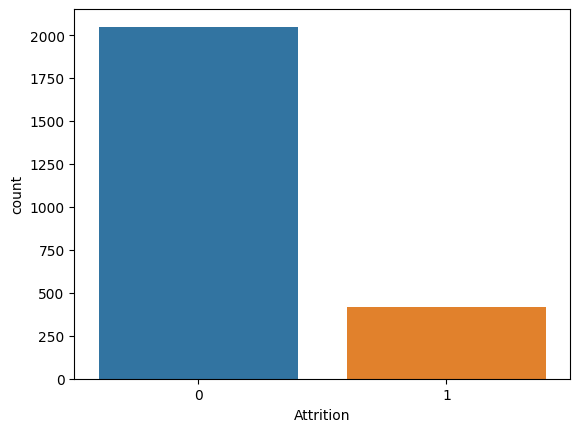

In [1332]:
sns.countplot(x = df['Attrition'])

([<matplotlib.patches.Wedge at 0x141b1bf10>,
 [Text(-0.9472151304674981, 0.5592705039723095, '0'),
  Text(0.9472151304674982, -0.5592705039723092, '1')],
 [Text(-0.5166627984368171, 0.3050566385303506, '83.0%'),
  Text(0.5166627984368171, -0.3050566385303504, '17.0%')])

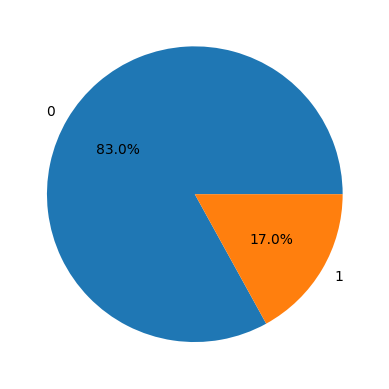

In [1333]:
plt.pie(df['Attrition'].value_counts()[[0,1]], autopct='%1.1f%%', labels=['0', '1'])


The majority of the Members of this dataset Stayed (0) at 83% and only 17% of the Members from this dataset left (1) the country club. After seeing these percentages, I can understand why the country club would be concerned about Member Attrition. Losing 17% of your memberbase is a lot. 

#### Age

In [1334]:
df['Age'].describe()

count    2468.000000
mean       40.354133
std        10.335446
min        18.000000
25%        32.000000
50%        40.000000
75%        48.000000
max        69.000000
Name: Age, dtype: float64

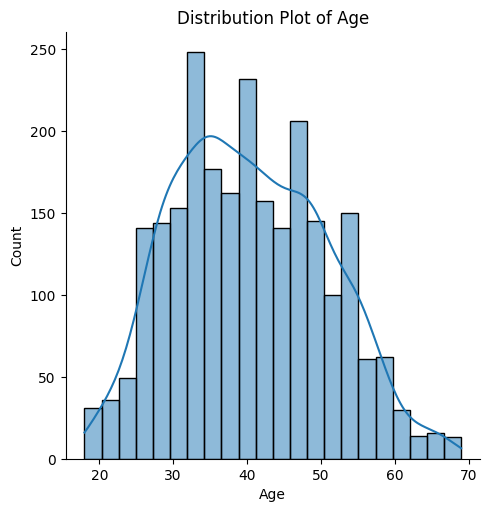

In [1335]:
sns.displot(df['Age'], kde=True).set(title = 'Distribution Plot of Age')

This feature seems to be approximately normally distributed with a slight positive skew. We can also see that the majority of datapoints fall within the 35-37.5 bucket. 

[Text(0.5, 1.0, 'BoxPlot of Age')]

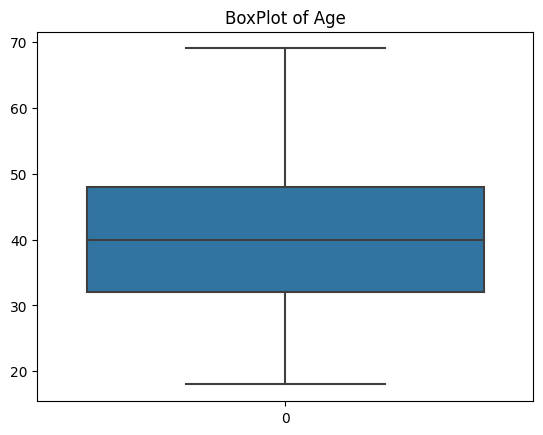

In [1336]:
sns.boxplot(df['Age']).set(title='BoxPlot of Age')

Again we can see the good distribution of this feature with it having no outliers.

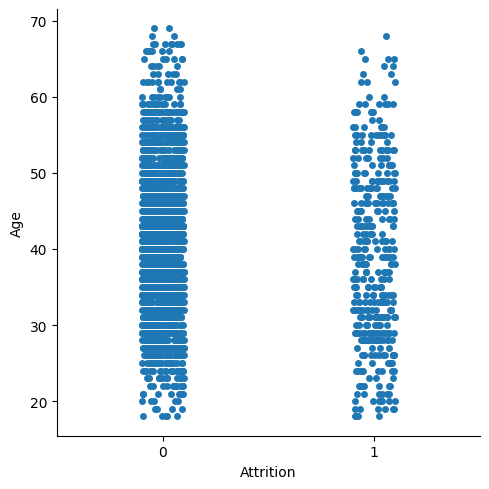

In [1337]:
sns.catplot(data=df, x= 'Attrition', y='Age')

#### Gender

<AxesSubplot: xlabel='Gender', ylabel='count'>

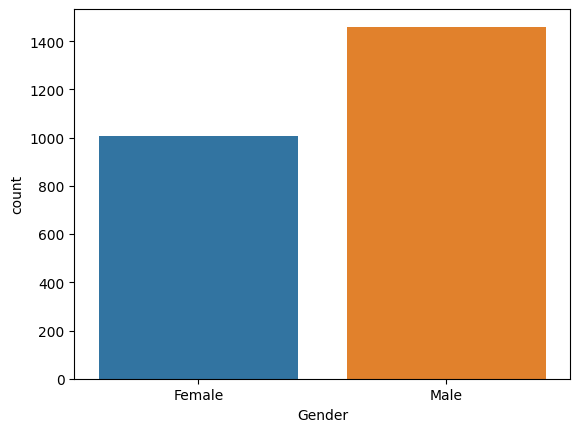

In [1338]:
sns.countplot(x = df['Gender'])

([<matplotlib.patches.Wedge at 0x141d74ca0>,
 [Text(-0.31210354361861437, 1.0547944719520974, 'Male'),
  Text(0.3121034448616274, -1.0547945011733353, 'Female')],
 [Text(-0.1702382965192442, 0.5753424392465984, '59.2%'),
  Text(0.17023824265179674, -0.5753424551854556, '40.8%')])

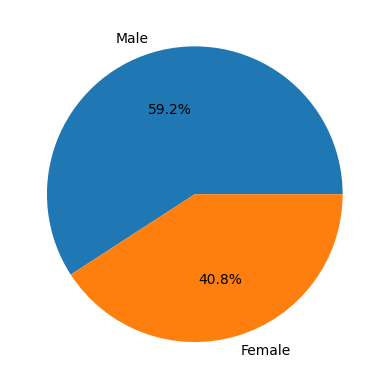

In [1339]:
plt.pie(df['Gender'].value_counts(), autopct='%1.1f%%', labels=['Male', 'Female'])


So 59.1% of the members of this dataset are Male and 40.9% are female. Lets see if there exists any obvious relationship between the Gender of the member and the Attrition. 

Text(0.5, 1.0, 'Female')

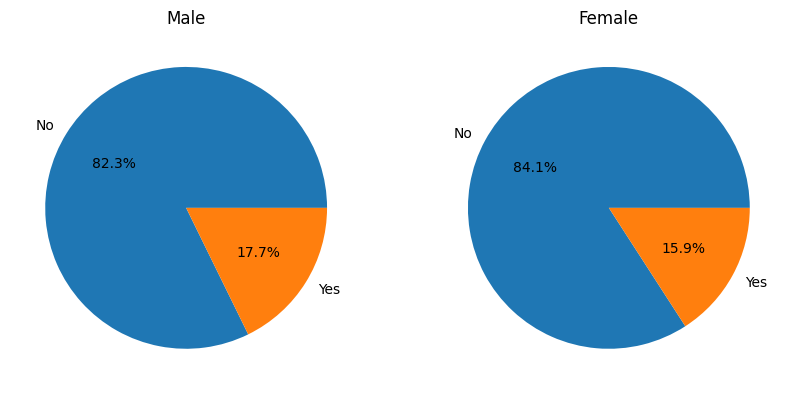

In [1340]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (10,5))
fig.add_subplot(1,2,1)
pie_jan = plt.pie(df[df['Gender'] == 'Male']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Male')
fig.add_subplot(1,2,2)
pie_jan = plt.pie(df[df['Gender'] == 'Female']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Female')

The distribution of members staying (No) and leaving (Yes) does not seem to differ much between the different Genders with 17.7% of the Male Members leaving and 15.9% of the Female Members. Not too big a difference. 

#### Monthly Income

In [1341]:
df['Monthly Income'].describe()

count     2468.000000
mean      6837.211912
std       4744.160002
min        854.000000
25%       3347.500000
50%       5393.000000
75%       8608.250000
max      25326.000000
Name: Monthly Income, dtype: float64

As we would expect with income, there is a large difference between the 75th Percentile (8608.25) and the max (25326). This is expected as the majority of people would earn within a particular range with very few outside that range on both sides. 

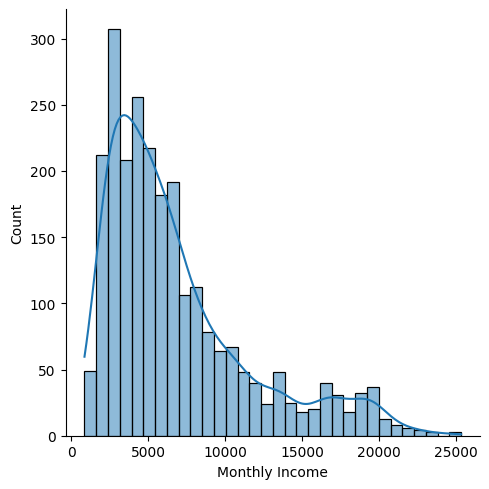

In [1342]:
sns.displot(df['Monthly Income'], kde=True)

As expected, the monthly income distribution plot is extremely positively skewed. Although we have a slight jump in the members earning between 15000-20000 per month. 

<AxesSubplot: >

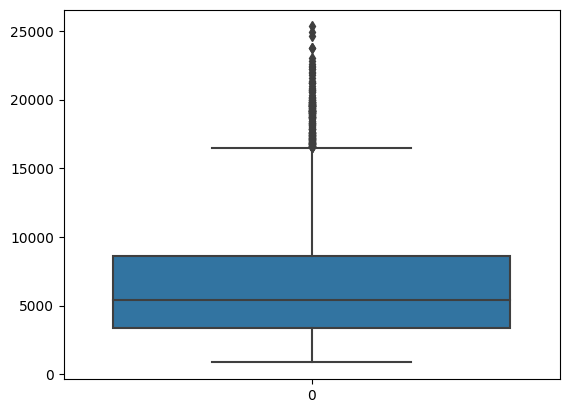

In [1343]:
sns.boxplot(df['Monthly Income'])

As expected from the distribution plot being so positively skewed, the boxplot also shows a lot of outliers above the upper whisker. However, this is expected as we saw from the distribution plot. 

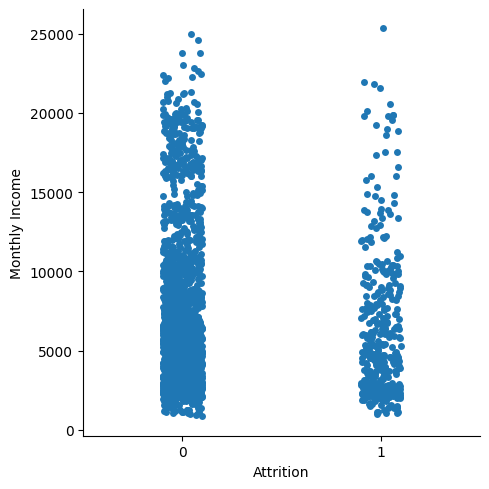

In [1344]:
sns.catplot(data=df, x= 'Attrition', y='Monthly Income')

This looks interesting. It seems that the members with higher Monthly Income tended to stay (0) as members. This makes me think this might be a useful feature. 

#### Travel Time

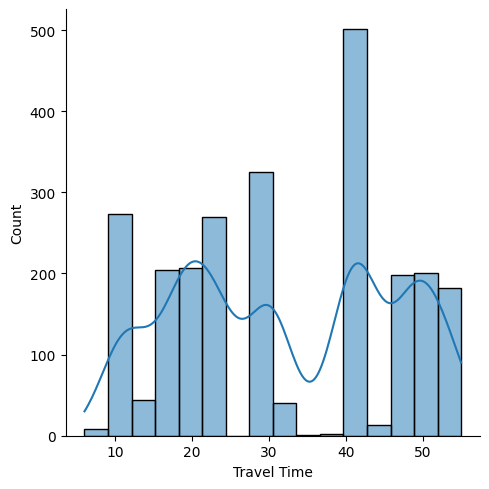

In [1345]:
sns.displot(df['Travel Time'], kde=True)

It seems that Travel Time varies greatly in terms of count. We have a mode around 40 minutes. There are many members who take < 20min but there do seem to be a lot more members who take >=40min to travel to the club. 

<AxesSubplot: >

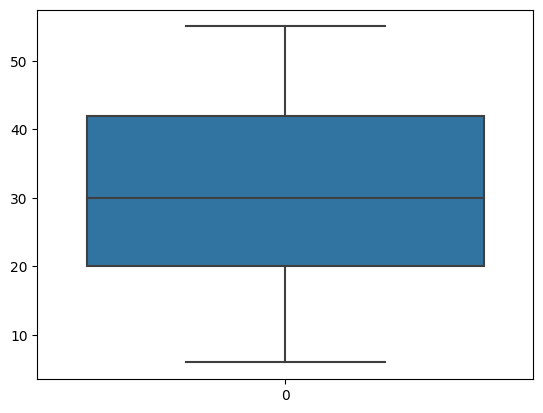

In [1346]:
sns.boxplot(df['Travel Time'])

However, based on the boxplot, there are no outliers. 

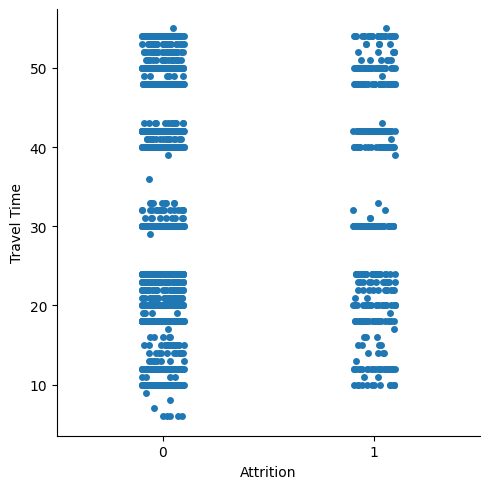

In [1347]:
sns.catplot(data=df, x= 'Attrition', y='Travel Time')

Now this is interesting. So its hard to tell for the members who lived further away (more even distributino between Attrition values) but for members that lived extremely close by (<10min away) the Attrition seems to be almost all 0 i.e the member stayed. Based on this, I am thinking about keeping this variable, perhaps even simplifying it to a simple categorical variable of near (<=10min travel time) and far( >10min travel time). 

#### Qualification

<AxesSubplot: xlabel='Qualification', ylabel='count'>

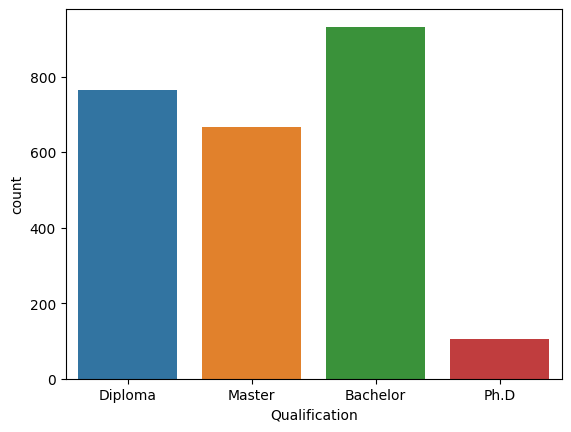

In [1348]:
sns.countplot(x = df['Qualification'])

Most members are Bachelor degree holders with roughly the same number of Master and Diploma holders. There are very few PhD holders among the members. 

([<matplotlib.patches.Wedge at 0x1421e4400>,
 [Text(0.6183843820637265, 0.9097256487643203, 'Diploma'),
  Text(-1.0347219553135485, 0.37329676557948754, 'Master'),
  Text(0.1285262685042771, -1.0924655593218335, 'Bachelor'),
  Text(1.0901892043374417, -0.14658614786566987, 'Ph.D')],
 [Text(0.3373005720347598, 0.4962139902350837, '31.0%'),
  Text(-0.5643937938073901, 0.20361641758881135, '27.0%'),
  Text(0.07010523736596931, -0.5958903050846365, '37.8%'),
  Text(0.5946486569113317, -0.07995608065400174, '4.3%')])

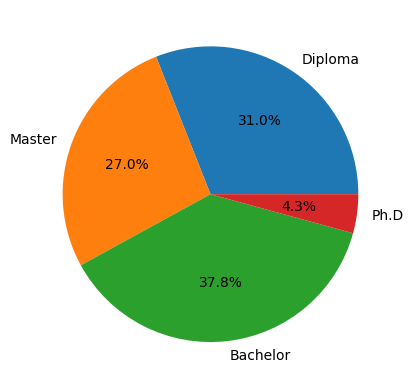

In [1349]:
qual = df['Qualification'].unique()
plt.pie(df['Qualification'].value_counts()[qual], autopct='%1.1f%%', labels=qual)

We are basically seeing the same thing as the CountPlot. But considering how small the number of Ph.D holders are it might be worth to just bunch them together with Master degree holders. Lets take a look at the relationship between Qualification feature and Attrition. 

Text(0.5, 1.0, 'Ph.D')

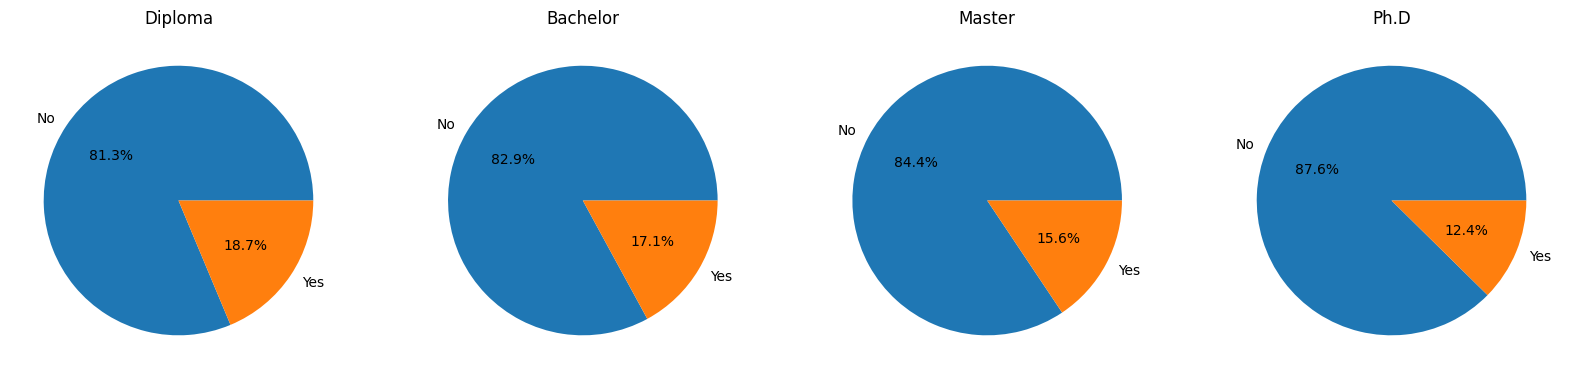

In [1350]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (20,5))
fig.add_subplot(1,4,1)
pie_dip = plt.pie(df[df['Qualification'] == 'Diploma']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Diploma')
fig.add_subplot(1,4,2)
pie_bach = plt.pie(df[df['Qualification'] == 'Bachelor']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Bachelor')
fig.add_subplot(1,4,3)
pie_mast = plt.pie(df[df['Qualification'] == 'Master']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Master')
fig.add_subplot(1,4,4)
pie_phd = plt.pie(df[df['Qualification'] == 'Ph.D']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Ph.D')

It seems that Diploma holders have the highest Attrition rate at 18.7%. While Ph.D holders have the lowest at 12.4%. Interestingly, it seems that the higher the education qualification, the lower the attrition. I wonder if maybe this has something to do with income.. We will have to find out in the later section. Consdering that Ph.D holders have a 3% lower attrition rate than the next lowest, I think it might be worthwhile to keep them seperate. Although, depending on the complexity of the model we decide on (number of features chosen) it maybe be worth it to just combine Master's and Ph.D holders into one group as there are so few Ph.D members relative to the other 3 groupds to reduce the complexity of the overall model. 

#### Work Domain

<AxesSubplot: xlabel='count', ylabel='Work Domain'>

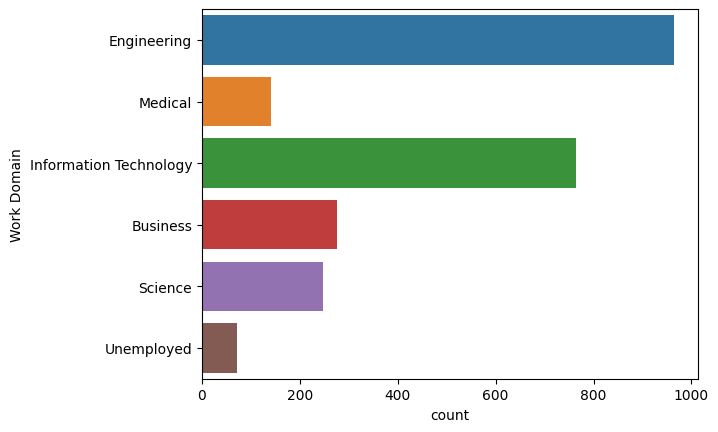

In [1351]:
sns.countplot(y= df['Work Domain'])

It seems that most members work domain is Engineering and Information Technology. With very few members being Medical or Unemployed. This makes sense as I would think that people working in the medical work domain would not have a lot of free time to enjoy a country club. Similarly, I would think that unemployed people(assuming not retired) would not want to waste money on a membership till they find a new job.  

([<matplotlib.patches.Wedge at 0x1423d2ac0>,
 [Text(0.3693426071386526, 1.0361399705406713, 'Engineering'),
  Text(-0.9631808540129309, 0.5313027785198581, 'Medical'),
  Text(-0.8753808694038284, -0.6661143546582657, 'Information Technology'),
  Text(0.43321020175548336, -1.011102824194935, 'Business'),
  Text(0.9658735810271041, -0.5263917034622396, 'Science'),
  Text(1.095383280276487, -0.10067506787046991, 'Unemployed')],
 [Text(0.20145960389381048, 0.5651672566585478, '39.1%'),
  Text(-0.525371374916144, 0.2898015155562862, '5.8%'),
  Text(-0.47748047422027, -0.36333510254087215, '31.0%'),
  Text(0.23629647368480905, -0.5515106313790553, '11.2%'),
  Text(0.526840135105693, -0.2871227473430397, '10.0%'),
  Text(0.59748178924172, -0.05491367338389267, '2.9%')])

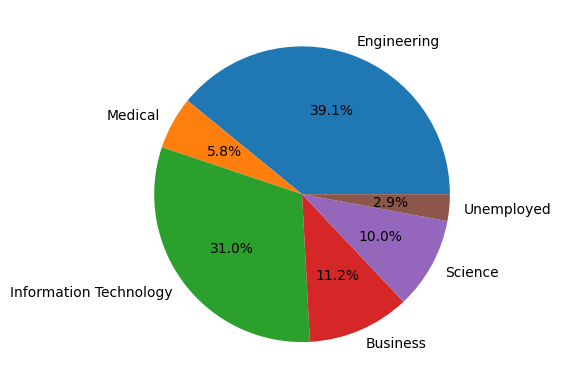

In [1352]:
work_domain = df['Work Domain'].unique()
plt.pie(df['Work Domain'].value_counts()[work_domain], autopct='%1.1f%%', labels=work_domain)

It seems that both Medical and Unemployed categories are very low percentages (5.8% and 2.9% respectively). This is even smaller than i thought from the countplot. Lets see if we can see any relationships between the different work domains and attrition. 

Text(0.5, 1.0, 'Engineering')

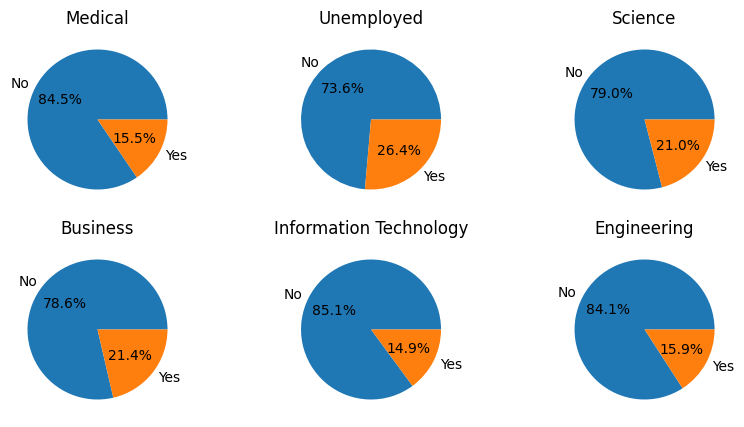

In [1353]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (10,5))
fig.add_subplot(2,3,1)
pie_dip = plt.pie(df[df['Work Domain'] == 'Medical']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Medical')
fig.add_subplot(2,3,2)
pie_bach = plt.pie(df[df['Work Domain'] == 'Unemployed']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Unemployed')
fig.add_subplot(2,3,3)
pie_mast = plt.pie(df[df['Work Domain'] == 'Science']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Science')
fig.add_subplot(2,3,4)
pie_phd = plt.pie(df[df['Work Domain'] == 'Business']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Business')
fig.add_subplot(2,3,5)
pie_phd = plt.pie(df[df['Work Domain'] == 'Information Technology']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Information Technology')
fig.add_subplot(2,3,6)
pie_phd = plt.pie(df[df['Work Domain'] == 'Engineering']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Engineering')

After looking at the relationship between work domain and attrition rate, I am thinking if I end up using this feature, it might be worthwhile to group Information Technology, Engineering and Medical together, Business and Science together and leaving Unemployed untouched. This would be able to potentially capture all the relevant information within this feature while reducing the complexity of the overall model. 

#### Usage Rate

I think it would make the most sense to treat this feature as categorical as there are only 4 different values that the feature takes: 

In [1354]:
df['Usage Rate'].unique()

array([2, 3, 4, 1])

<AxesSubplot: xlabel='Usage Rate', ylabel='count'>

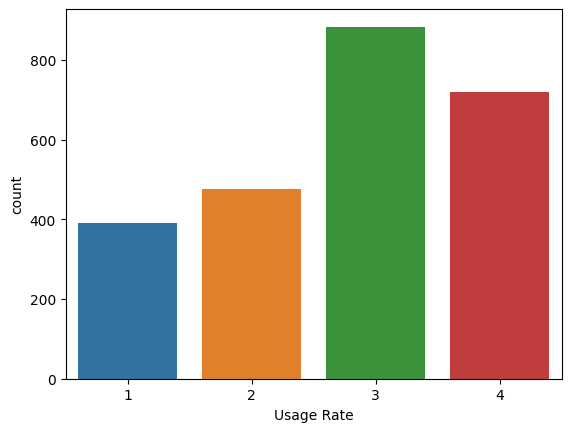

In [1355]:
sns.countplot(x = df['Usage Rate'])

The largest number of members visit the country club 3 times a week with the 2nd largest being 4. With the least number of members visiting the country club once a week. This is interesting as this means that the country club does not have any non-active members (members that have a membership but do not visit the club) as the minimum usage rate is 1. 

([<matplotlib.patches.Wedge at 0x14265b790>,
 [Text(0.9033813275425736, 0.6276162657607095, '2'),
  Text(-0.7638331902002933, 0.7915547091316195, '3'),
  Text(-0.36274040194136326, -1.0384697399536582, '4'),
  Text(0.9672106506899111, -0.5239308706232139, '1')],
 [Text(0.4927534513868582, 0.342336144960387, '19.3%'),
  Text(-0.41663628556379634, 0.4317571140717924, '35.8%'),
  Text(-0.19785840105892538, -0.5664380399747226, '29.1%'),
  Text(0.5275694458308605, -0.2857804748853894, '15.8%')])

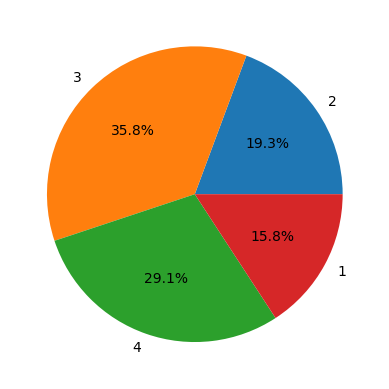

In [1356]:
usage_rate = df['Usage Rate'].unique()
plt.pie(df['Usage Rate'].value_counts()[usage_rate], autopct='%1.1f%%', labels=usage_rate)

Nothing much new here to gather from the breakdown in terms of percentages of the 4 usage rates. But it is still useful to see the percentage differences. Now lets see if we can see any obvious relationship between the usage rate and member attrition. I am expecting that the members with a higher usage rate would have a lower attrition rate. 

Text(0.5, 1.0, '4')

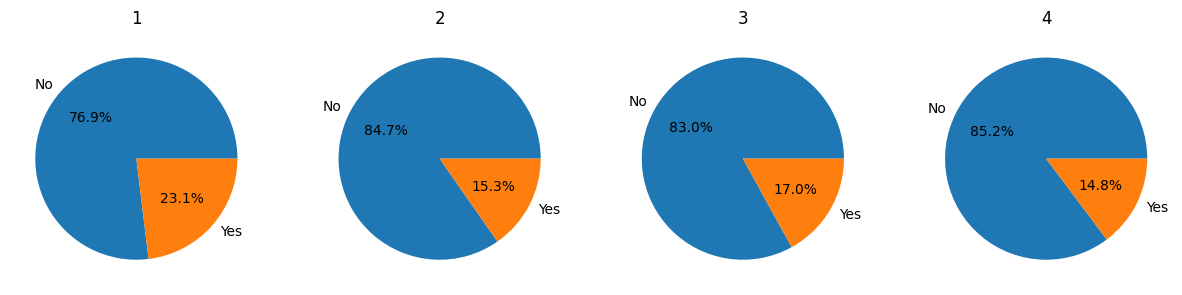

In [1357]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (15,5))
fig.add_subplot(1,4,1)
pie_dip = plt.pie(df[df['Usage Rate'] == 1]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1')
fig.add_subplot(1,4,2)
pie_bach = plt.pie(df[df['Usage Rate'] == 2]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2')
fig.add_subplot(1,4,3)
pie_mast = plt.pie(df[df['Usage Rate'] == 3]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('3')
fig.add_subplot(1,4,4)
pie_phd = plt.pie(df[df['Usage Rate'] == 4]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('4')

In general the trend I expected seems to be the case. With the members with the highest usage rate also having the lowest attrition rate. Similarly, the members with the lowest usage rate seem to have the highest attrition rate. I am unsure why the members with usage rate = 2 have a lower attrition rate than the members with usage rate =3 but the information gathered here is extremely useful. I think this might be a very useful feature to keep in the model. 

#### Branch

<AxesSubplot: xlabel='Branch', ylabel='count'>

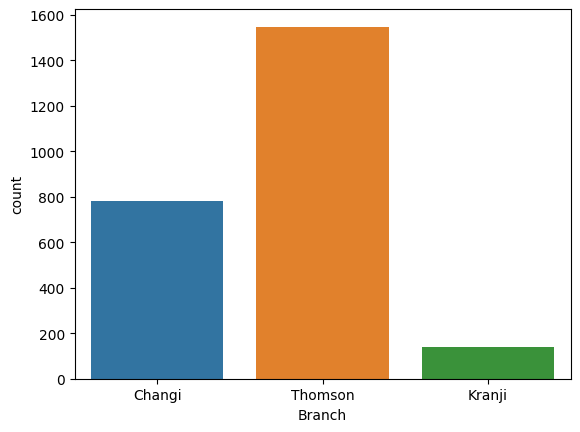

In [1358]:
sns.countplot(x = df['Branch'])

From the countplot, we can see that the majority of members visit the Thomson Branch by a large margin. With the lowest number of members visiting the Kranji branch. Lets take a look at a piechart of this so we can see this information in percentages. 

([<matplotlib.patches.Wedge at 0x142847670>,
 [Text(0.5985548000176508, 0.9228933586150841, 'Changi'),
  Text(-0.7516533128367009, -0.8031296889678609, 'Thomson'),
  Text(1.082826160759706, -0.19361690415455846, 'Kranji')],
 [Text(0.326484436373264, 0.5033963774264094, '31.7%'),
  Text(-0.4099927160927459, -0.43807073943701497, '62.7%'),
  Text(0.590632451323476, -0.10560922044794097, '5.6%')])

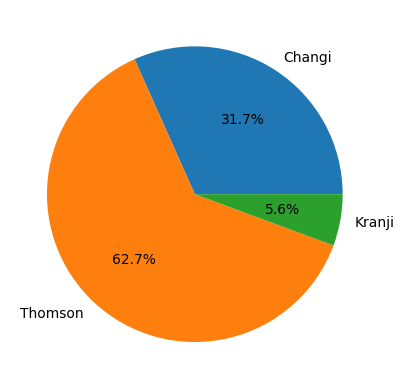

In [1359]:
bra = df['Branch'].unique()
plt.pie(df['Branch'].value_counts()[bra], autopct='%1.1f%%', labels=bra)

Only 5.6% of members visit Kranji. This is much lower than I thought from the countplot. Lets see if there is any obvious relationship between Branch member visits and member attrition. 

Text(0.5, 1.0, 'Kranji')

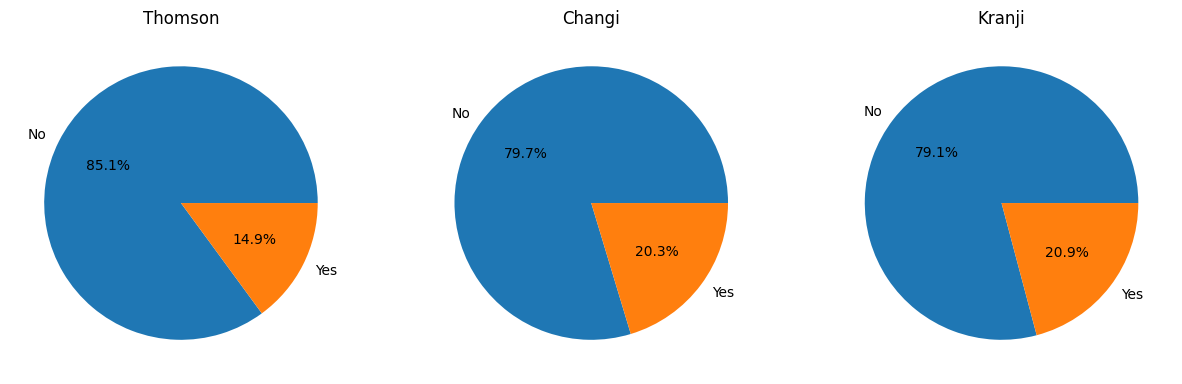

In [1362]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (15,5))
fig.add_subplot(1,3,1)
pie_dip = plt.pie(df[df['Branch'] == 'Thomson']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Thomson')
fig.add_subplot(1,3,2)
pie_bach = plt.pie(df[df['Branch'] == 'Changi']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Changi')
fig.add_subplot(1,3,3)
pie_mast = plt.pie(df[df['Branch'] == 'Kranji']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Kranji')

This is very interesting. It seems that members that visit the Thomson branch have a significantly lower attrition rate (14.9%) compared to the Changi Branch (20.3%) and the Kranji Branch (20.9%). I think considering how small the number of members that visit Kranji is, it's a good idea to merge Changi and Kranji into one category because their attrition rates are similar and the count of both are significantly smaller than the Thomson branch. 

#### Membership

<AxesSubplot: xlabel='Membership', ylabel='count'>

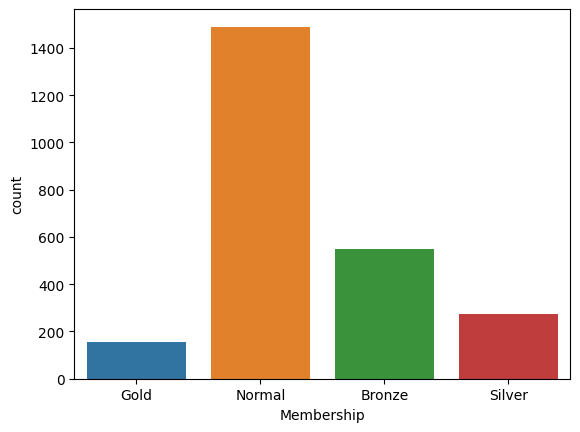

In [1363]:
sns.countplot(x = df['Membership'])

The most number of members have a normal membership with the least having a Gold membership. This is very much what I would have expected as this is typically how membership tier numbers work. With the least being gold, 2nd least count being silver and the 3rd least being Bronze. Lets take a look at the percentages. 

([<matplotlib.patches.Wedge at 0x1432a41c0>,
 [Text(1.0783830822972522, 0.2170021378122301, 'Gold'),
  Text(-0.7278210649839412, 0.8247887592381712, 'Normal'),
  Text(0.1922385295407954, -1.083071718659477, 'Bronze'),
  Text(1.0337682448339025, -0.3759298019218918, 'Silver')],
 [Text(0.5882089539803192, 0.11836480244303457, '6.3%'),
  Text(-0.3969933081730588, 0.44988477776627517, '60.4%'),
  Text(0.10485737974952475, -0.5907663919960783, '22.2%'),
  Text(0.5638735880912195, -0.20505261923012277, '11.1%')])

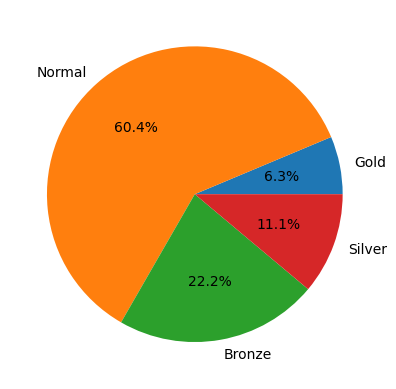

In [1364]:
mem = df['Membership'].unique()
plt.pie(df['Membership'].value_counts()[mem], autopct='%1.1f%%', labels=mem)

Nothing too interesting here. Lets see if there is any  obvious relationship between the membership tier and attrition. 

Text(0.5, 1.0, 'Gold')

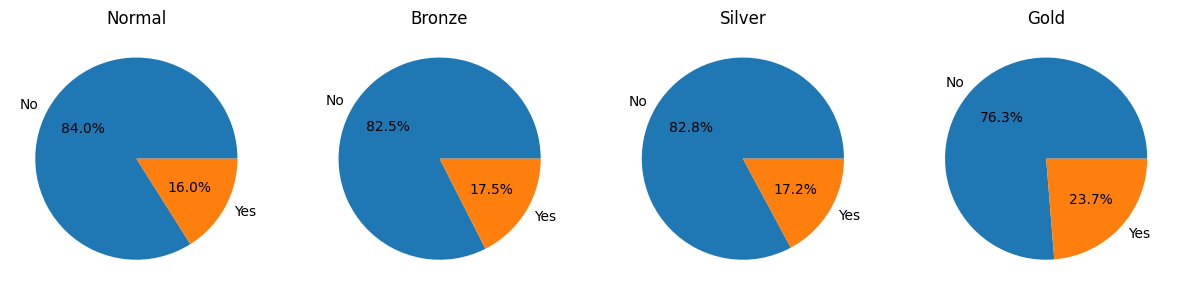

In [1365]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (15,5))
fig.add_subplot(1,4,1)
pie_dip = plt.pie(df[df['Membership'] == 'Normal']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Normal')
fig.add_subplot(1,4,2)
pie_bach = plt.pie(df[df['Membership'] == 'Bronze']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Bronze')
fig.add_subplot(1,4,3)
pie_mast = plt.pie(df[df['Membership'] == 'Silver']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Silver')
fig.add_subplot(1,4,4)
pie_mast = plt.pie(df[df['Membership'] == 'Gold']['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Gold')

Now this is interesting! It seems that gold members have the highest attrition rates at 23.7% compared to the between 16-17.5% of the other membership tiers. This indicates to me that the country club should consider focusing their attention on try to retain the gold tier members. However, we also need to consider that gold members only account for 6.3% of all members (from the pie chart) so it might not be worth it in terms of actual number of members. It is probably much more worth it to focus their efforts on reducing the percetage of normal and Bronze members from leaving. 

#### Months

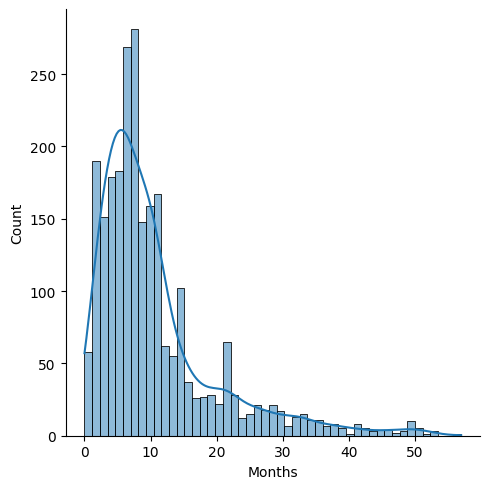

In [1367]:
sns.displot(x = df['Months'], kde=True)

The datapoints for months looks to be distributed in a roughly postive-skewed normal distribution. It seems that most members have been members for less than 10 months. 

<AxesSubplot: >

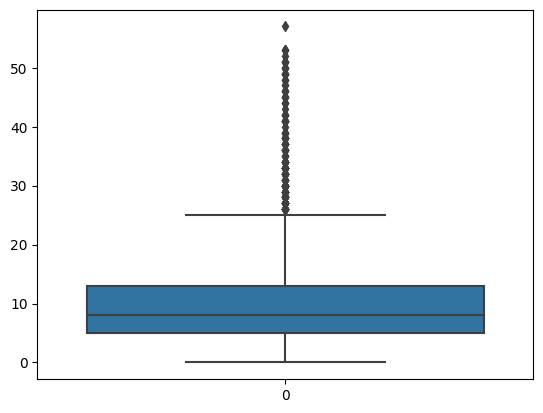

In [1368]:
sns.boxplot(df['Months'])

As expected from the high positive skew of the distribution plot, there are many outliers outside the upper whisker of the boxplot. I do not think they are outliers so much as its just the natural distribution as most members would not stay for many months. Lets now take a look if we can see a relationship between Months and Attrition. I suspect that the members that have been members of the country club for a long time would be less likely to leave. 

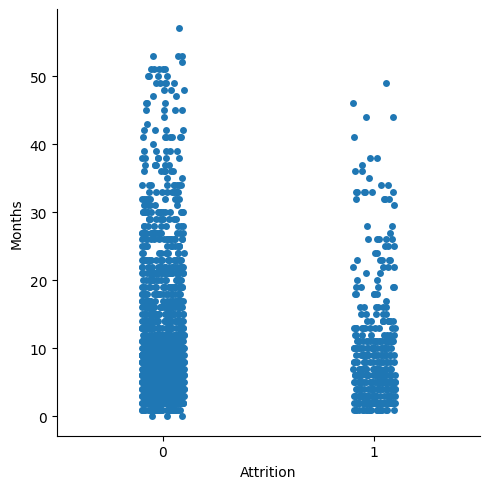

In [1369]:
sns.catplot(data=df, x= 'Attrition', y='Months')

It seems that my hypothesis holds true for members who have been members for more than 50 months. However, we can see from this trend, that generally once members have been members for more than 20 months, they tend not to leave. We can see this from the density of the Months of the members who left (1). Its extremely dense at the lower months, but then very low density after 20 months. This seems like a very useful feature to use for our model!

#### Usage Time

In [1374]:
df['Usage Time'].unique()

array([ 7,  2,  0, 15,  5,  6, 12,  4,  9,  3, 10, 17,  1,  8, 13, 18, 16,
       14, 11])

As we can see, there are 19 different values for the usage time feature. I think this might be too many 'categories' to be able to treat this as a categorical variable in its current state because if I want to include it in my model, it would add a fair amount of complexity to the model. I will start the univariate analysis by treating it as a cateogrical feature with the intention of trying to reduce the number of categories. If that does not seem possible, then I will treat it as a numerical feature. 

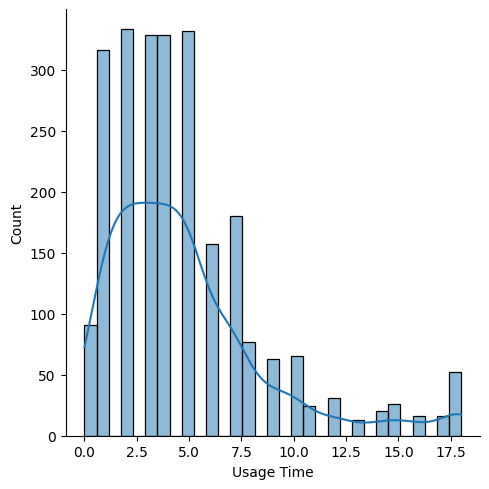

In [1382]:
sns.displot(df['Usage Time'], kde=True)

We can see that most members seem to have a usage time of between 1 and 5 hours per visit. Interestingly, there is a spike in the number of members that have a usage time of >= 18 hours. Which is not something I expected. 

([<matplotlib.patches.Wedge at 0x1437fe9d0>,
 [Text(1.0712514292204933, 0.2498407000331422, '7'),
  Text(0.6990496005404776, 0.8493112833256127, '2'),
  Text(0.16322122483169133, 1.087822978137731, '0'),
  Text(2.2528938382247463e-08, 1.0999999999999999, '15'),
  Text(-0.48410912166008696, 0.9877440753178423, '5'),
  Text(-0.9692043355557948, 0.5202335590288756, '6'),
  Text(-1.0648961604946963, 0.2756740237375553, '12'),
  Text(-1.0772641898693787, -0.22249014635500453, '4'),
  Text(-0.8403443028133062, -0.7098038128449429, '9'),
  Text(-0.39951546626108836, -1.024884087210932, '3'),
  Text(0.1410333063568479, -1.0909214483628304, '10'),
  Text(0.2525671506517104, -1.0706118971932248, '17'),
  Text(0.6694524104571028, -0.8728307224961637, '1'),
  Text(1.0060735361418631, -0.44476515137205547, '8'),
  Text(1.0503210466339088, -0.32684200923053097, '13'),
  Text(1.0737400764185616, -0.23891891572803822, '18'),
  Text(1.0903749177631794, -0.1451982737946283, '16'),
  Text(1.0958816921440

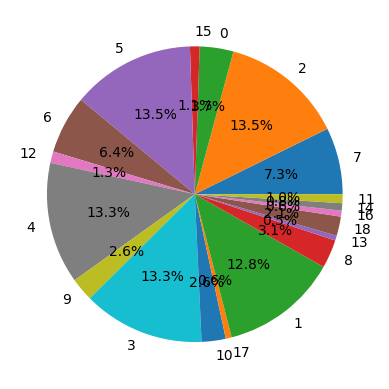

Text(0.5, 1.0, '18')

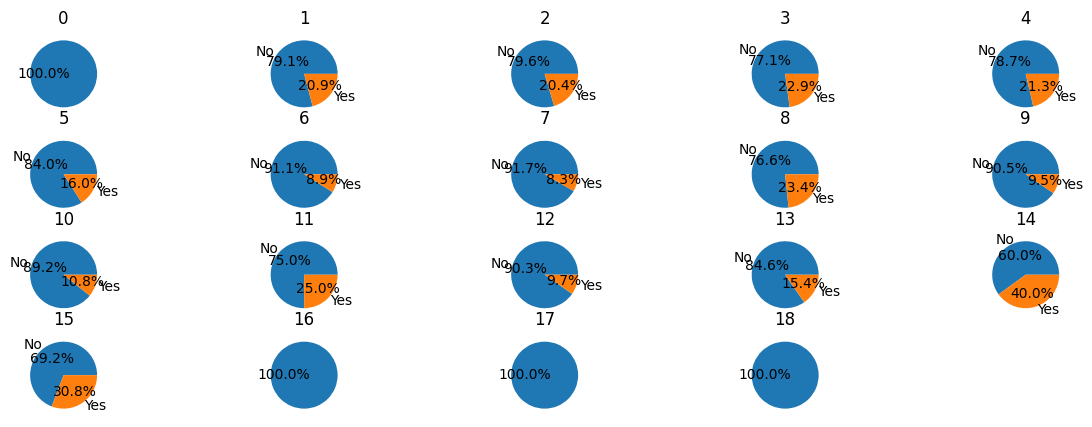

In [1387]:
labels = [0, 1]
labels2 = ['No', 'Yes']
fig = plt.figure(figsize = (15,5))
fig.add_subplot(4,5,1)
pie_dip = plt.pie(df[df['Usage Time'] == 0]['Attrition'].value_counts(), autopct='%1.1f%%')
plt.title('0')
fig.add_subplot(4,5,2)
pie_dip = plt.pie(df[df['Usage Time'] == 1]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1')
fig.add_subplot(4,5,3)
pie_dip = plt.pie(df[df['Usage Time'] == 2]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2')
fig.add_subplot(4,5,4)
pie_dip = plt.pie(df[df['Usage Time'] == 3]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('3')
fig.add_subplot(4,5,5)
pie_dip = plt.pie(df[df['Usage Time'] == 4]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('4')
fig.add_subplot(4,5,6)
pie_dip = plt.pie(df[df['Usage Time'] == 5]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('5')
fig.add_subplot(4,5,7)
pie_dip = plt.pie(df[df['Usage Time'] == 6]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('6')
fig.add_subplot(4,5,8)
pie_dip = plt.pie(df[df['Usage Time'] == 7]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('7')
fig.add_subplot(4,5,9)
pie_dip = plt.pie(df[df['Usage Time'] == 8]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('8')
fig.add_subplot(4,5,10)
pie_dip = plt.pie(df[df['Usage Time'] == 9]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('9')
fig.add_subplot(4,5,11)
pie_dip = plt.pie(df[df['Usage Time'] == 10]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('10')
fig.add_subplot(4,5,12)
pie_dip = plt.pie(df[df['Usage Time'] == 11]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('11')
fig.add_subplot(4,5,13)
pie_dip = plt.pie(df[df['Usage Time'] == 12]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('12')
fig.add_subplot(4,5,14)
pie_dip = plt.pie(df[df['Usage Time'] == 13]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('13')
fig.add_subplot(4,5,15)
pie_dip = plt.pie(df[df['Usage Time'] == 14]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('14')
fig.add_subplot(4,5,16)
pie_dip = plt.pie(df[df['Usage Time'] == 15]['Attrition'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('15')
fig.add_subplot(4,5,17)
pie_dip = plt.pie(df[df['Usage Time'] == 16]['Attrition'].value_counts(), autopct='%1.1f%%')
plt.title('16')
fig.add_subplot(4,5,18)
pie_dip = plt.pie(df[df['Usage Time'] == 17]['Attrition'].value_counts(), autopct='%1.1f%%')
plt.title('17')
fig.add_subplot(4,5,19)
pie_dip = plt.pie(df[df['Usage Time'] == 18]['Attrition'].value_counts(), autopct='%1.1f%%')
plt.title('18')

Interestingly, it seems that all members who have usage time = 0 did not leave the country club. That does seem odd. As expected, the members with usage time >= 16 none of them left which makes sense. I think moving forward, considering the number of categories here, I will just group 1-4 together, 6-7 together, 9-10 together, bringing us down to 12 different categories. I will think abou grouping more if I feel that the model is getting too complex. 

#### Client Age

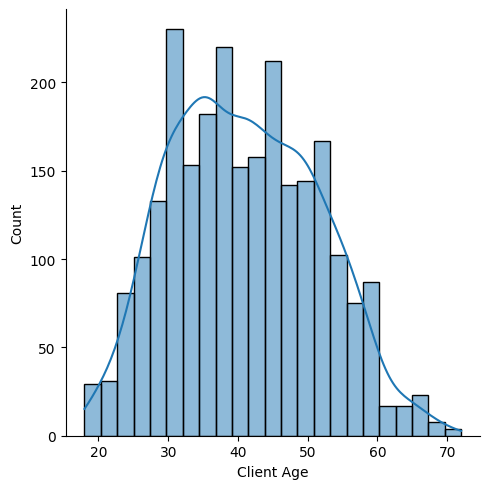

In [1389]:
sns.displot(df['Client Age'], kde=True)

It seems that the client age is relatively normally distributed with a slight positive skew. 

<AxesSubplot: >

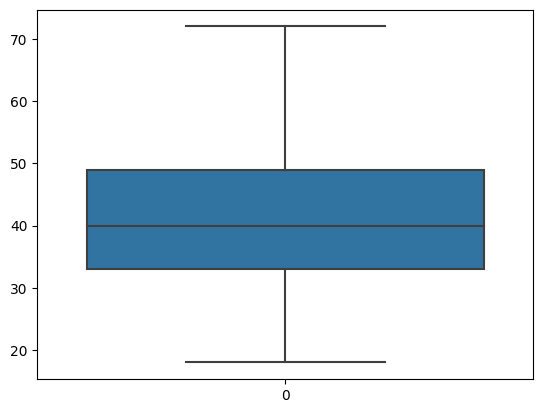

In [1390]:
sns.boxplot(df['Client Age'])

As expected, from the distribution plot, there are no outliers. We can again see the positive skew from the whisker length difference.

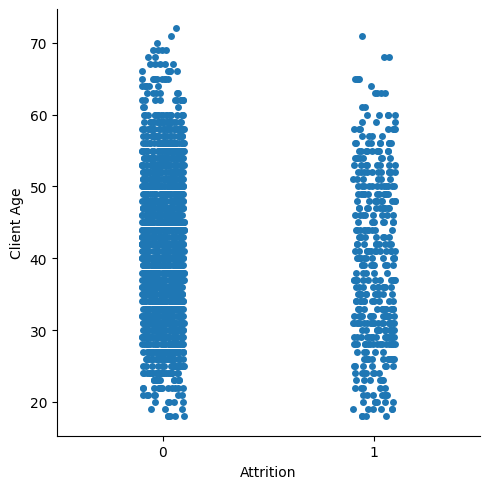

In [1391]:
sns.catplot(data=df, x= 'Attrition', y='Client Age')

There does not seem to be much of a relationship between Client Age and Attritioin. While Client Age does seem to be more dense at for example the 20-30 secition I think we can attribute a lot of that to there simply being more datapoints with Attrition = 0 rather than 1 as seen earlier. 

#### Weekly Hours

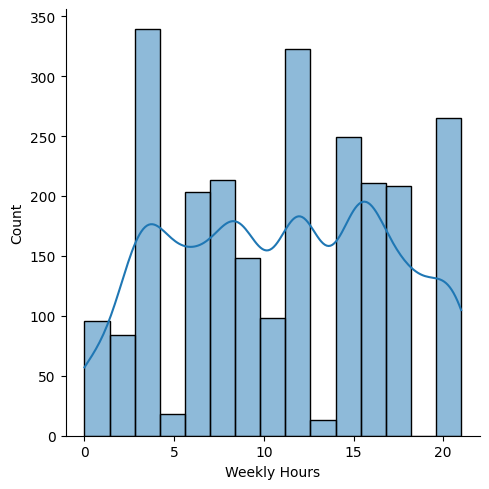

In [1396]:
sns.displot(df['Weekly Hours'], kde=True)

<AxesSubplot: >

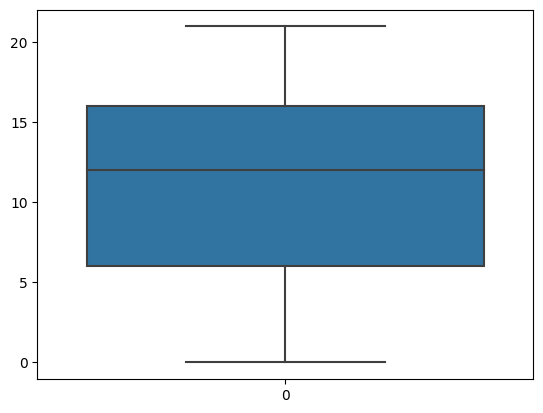

In [1395]:
sns.boxplot(df['Weekly Hours'])

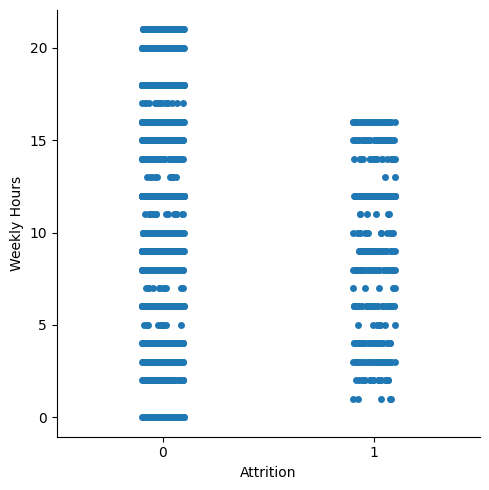

In [1397]:
sns.catplot(data=df, x= 'Attrition', y='Weekly Hours')

#### Total Hours

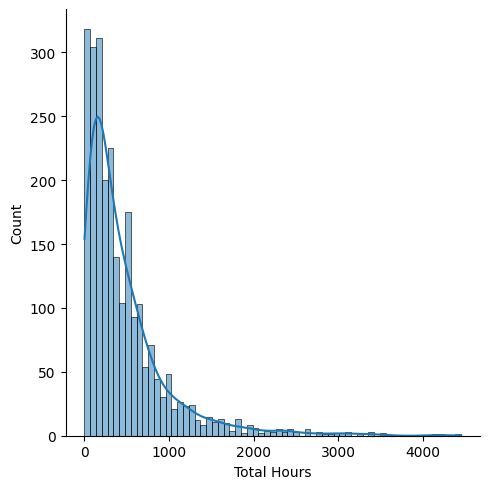

In [1399]:
sns.displot(df['Total Hours'], kde=True)

This feature looks a lot more promising. It seems to look like a pareto distribution. Which would be expected cause from the other features we have seen, very few members have been members for many months and also very few members spend a large number of hours per visit at the country club. 

<AxesSubplot: >

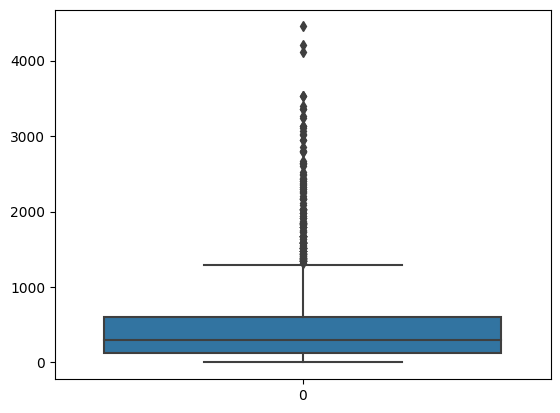

In [1400]:
sns.boxplot(df['Total Hours'])

Considering the pareto distribution appearance of the distribution plot, it makes a lot of sense for there to be a large number of outliers above the upper whisker. Lets see if there is any obvious relationship between Total Hours and Attrition. 

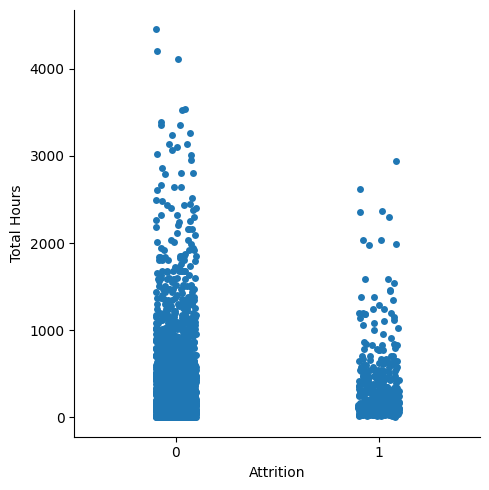

In [1401]:
sns.catplot(data=df, x= 'Attrition', y='Total Hours')

This is interesting. So by combining the 3 features of Months, Usage Time and Usage Rate, what has occurred is that we have made the larger values of those 3 features get larger. We can see this because above 1000 total hours we can see a clear larger amount of datapoints with Attrition=0 rather than Attrition= 1. This seems like a useful feature and seeing as it is a combination of Months, Usage Rate and Usage Time, we might be able to use this feature in place of those 3 which would allow us to reduce the complexity of our model by using less features. 